# Simple Forecasting Comparison

Compare three forecasting algorithms for electricity day-ahead prices.
Train on historical data and forecast the next 24 hours.

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

from datamanager import DataManager
from logger import setup_logger

logger = setup_logger(__name__)

# Setup plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

## 1. Load Data

In [2]:
# Initialize DataManager and load price data
dm = DataManager(read_mode='data')

# Select a country for analysis (change as needed)
COUNTRY = 'DK_1'  # Denmark - Western

if COUNTRY not in dm.data:
    print(f"Available countries: {list(dm.data.keys())}")
    COUNTRY = list(dm.data.keys())[0]
    print(f"Using {COUNTRY} instead")

df = dm.data[COUNTRY].copy()
df['time'] = pd.to_datetime(df['time'], utc=True)
df = df.sort_values('time').reset_index(drop=True)

print(f"\nLoaded {len(df)} records for {COUNTRY}")
print(f"Date range: {df['time'].min()} to {df['time'].max()}")
print(f"\nFirst rows:")
print(df.head())
print(f"\nPrice statistics:")
print(df['price'].describe())

2026-02-08 18:36:42,595 - datamanager - INFO - DataManager initialized with read_mode=data



Loaded 26103 records for DK_1
Date range: 2023-12-31 23:00:00+00:00 to 2026-01-21 02:00:00+00:00

First rows:
                       time  price
0 2023-12-31 23:00:00+00:00  16.99
1 2024-01-01 00:00:00+00:00  28.14
2 2024-01-01 01:00:00+00:00  26.66
3 2024-01-01 02:00:00+00:00   4.14
4 2024-01-01 03:00:00+00:00  -0.03

Price statistics:
count    26103.000000
mean        80.103329
std         49.573354
min        -60.050000
25%         53.765000
50%         81.620000
75%        102.655000
max        936.280000
Name: price, dtype: float64


## 2. Data Preparation

In [3]:
# Clean the data
df['price'] = df['price'].ffill().bfill()
df = df.sort_values('time').reset_index(drop=True)
df = df.set_index('time').sort_index()
df = df.resample('15min').ffill().dropna()
df = df.reset_index()
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['time'].min()} to {df['time'].max()}")
print(f"\nPrice statistics:")
print(df['price'].describe())

Dataset shape: (72109, 2)
Date range: 2023-12-31 23:00:00+00:00 to 2026-01-21 02:00:00+00:00

Price statistics:
count    72109.000000
mean        76.612930
std         50.763908
min        -60.050000
25%         46.300000
50%         79.090000
75%        102.390000
max        936.280000
Name: price, dtype: float64


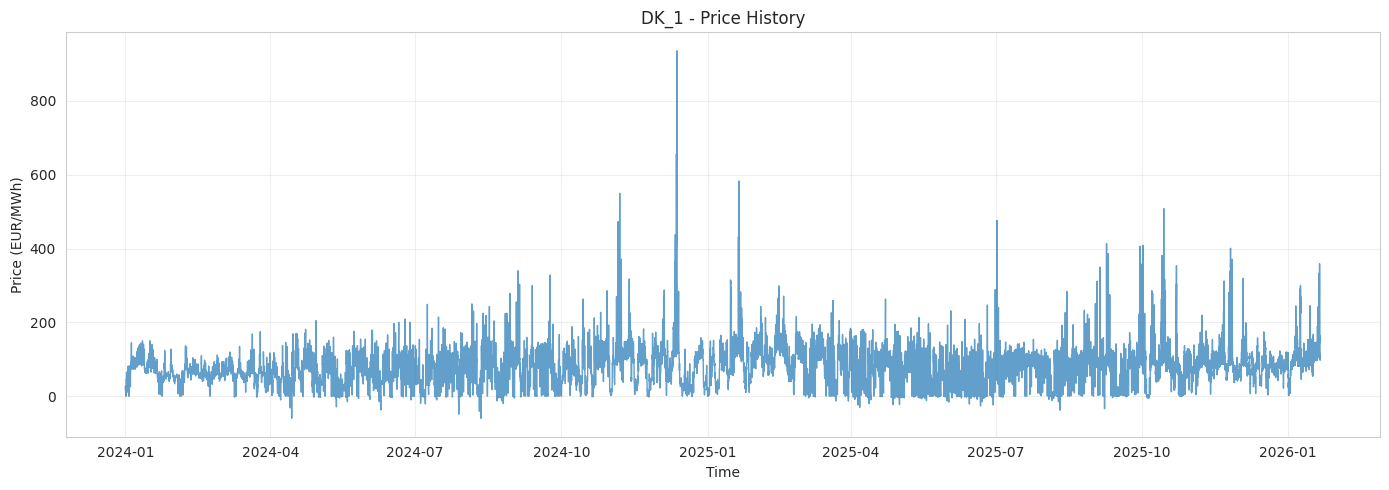

In [4]:
# Visualize the data
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df['time'], df['price'], linewidth=1, alpha=0.7)
ax.set_title(f'{COUNTRY} - Price History')
ax.set_ylabel('Price (EUR/MWh)')
ax.set_xlabel('Time')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
# Setup for walk-forward validation: test on multiple dates
# We'll test every 96 observations (24 hours) going backwards from the end
test_window = 96  # 24 hours of data to forecast
num_tests = 5  # Number of different test periods
step = 96  # Move back 24 hours for each test

print(f"Setting up {num_tests} test windows of {test_window} observations each")
print(f"(Step size: {step} observations between tests)")

Setting up 5 test windows of 96 observations each
(Step size: 96 observations between tests)


## 3. Three Forecasting Algorithms

1. **Naive**: Use the last known price
2. **Seasonal Naive**: Use the price from 24 hours ago
3. **ARIMA**: Statistical model that learns patterns

In [6]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import time
import sys

# ---------------------------------------------------------
# 1. ROBUST DATA SETUP (Fixes Index/Column issues)
# ---------------------------------------------------------
print("Preparing data...", end=" ")

# Safety check: ensure 'time' is available as a column
if 'time' not in df.columns:
    if df.index.name == 'time':
        df = df.reset_index()
    elif isinstance(df.index, pd.DatetimeIndex):
        df = df.reset_index()
        if 'index' in df.columns: df = df.rename(columns={'index': 'time'})

# Standardize to 15-min frequency
df['time'] = pd.to_datetime(df['time'], utc=True)
df = df.set_index('time').sort_index()
df_15min = df.resample('15min').ffill().dropna().reset_index()

# Constants
steps_per_day = 96
steps_per_week = 96 * 7
horizon = 96
num_tests = 5
test_window = 96

# Limit training history to last 6 months (Speed optimization)
TRAIN_HISTORY_LIMIT = 96 * 180 

print(f"Done. Shape: {df_15min.shape}")
print("-" * 60)

# ---------------------------------------------------------
# 2. FEATURE ENGINEERING
# ---------------------------------------------------------
def create_direct_features(prices, times, start_idx, end_idx):
    X, y = [], []
    for i in range(start_idx, end_idx):
        # Targets
        target = prices[i : i + horizon]
        # Features
        lag_day = prices[i - steps_per_day : i]
        lag_week = prices[i - steps_per_week : i - steps_per_week + steps_per_day]
        t = times.iloc[i]
        
        row = np.concatenate([lag_day, lag_week, [t.hour, t.dayofweek]])
        X.append(row)
        y.append(target)
    return np.array(X), np.array(y)

# Storage
results = {
    'Naive': [], 'Seasonal Naive': [], 
    'Random Forest': [], 'Gradient Boosting': []
}
forecasts = {
    'Actual': [], 'Naive': [], 'Seasonal Naive': [], 
    'Random Forest': [], 'Gradient Boosting': []
}
test_dates = []

# ---------------------------------------------------------
# 3. TRAINING LOOP WITH PROGRESS UPDATES
# ---------------------------------------------------------
total_start = time.time()

for test_idx in range(num_tests):
    fold_start = time.time()
    
    # --- A. Setup Fold ---
    test_start = len(df_15min) - (test_window * (num_tests - test_idx))
    test_end = test_start + test_window
    train_end = test_start
    
    test_date_str = df_15min['time'].iloc[test_start]
    test_dates.append(test_date_str)
    
    print(f"Fold {test_idx+1}/{num_tests} | Target Date: {test_date_str}")
    
    # --- B. Data Prep ---
    print(f"  > [1/4] Generating features...", end=" ", flush=True)
    
    train_start_idx = max(steps_per_week, train_end - TRAIN_HISTORY_LIMIT)
    
    prices_all = df_15min['price'].values
    times_all = df_15min['time']
    
    # Train Data
    X_train, y_train = create_direct_features(
        prices_all, times_all, 
        start_idx=train_start_idx, 
        end_idx=train_end - horizon + 1
    )
    
    # Test Input
    last_day = prices_all[train_end - steps_per_day : train_end]
    last_week = prices_all[train_end - steps_per_week : train_end - steps_per_week + steps_per_day]
    curr_t = times_all.iloc[train_end]
    X_curr = np.concatenate([last_day, last_week, [curr_t.hour, curr_t.dayofweek]]).reshape(1, -1)
    
    print(f"Done ({len(X_train)} samples)", flush=True)

    # --- C. Baselines ---
    prices_test = prices_all[test_start:test_end]
    forecast_naive = np.array([prices_all[train_end-1]] * len(prices_test))
    forecast_seasonal = prices_all[train_end - steps_per_day : train_end]

    # --- D. Random Forest ---
    print(f"  > [2/4] Training Random Forest...", end=" ", flush=True)
    t0 = time.time()
    # max_samples=0.2 makes it train on random 20% of data per tree (Very Fast)
    rf = MultiOutputRegressor(RandomForestRegressor(
        n_estimators=30, max_depth=15, max_samples=0.2, n_jobs=-1, random_state=42
    ))
    rf.fit(X_train, y_train)
    forecast_rf = rf.predict(X_curr)[0]
    print(f"{time.time()-t0:.1f}s", flush=True)
    
    # --- E. Gradient Boosting ---
    print(f"  > [3/4] Training HistGradientBoosting...", end=" ", flush=True)
    t0 = time.time()
    gb = MultiOutputRegressor(HistGradientBoostingRegressor(
        max_iter=100, max_depth=5, learning_rate=0.1, random_state=42
    ))
    gb.fit(X_train, y_train)
    forecast_gb = gb.predict(X_curr)[0]
    print(f"{time.time()-t0:.1f}s", flush=True)
    
    # --- F. Save Results ---
    results['Naive'].append(mean_absolute_error(prices_test, forecast_naive))
    results['Seasonal Naive'].append(mean_absolute_error(prices_test, forecast_seasonal))
    results['Random Forest'].append(mean_absolute_error(prices_test, forecast_rf))
    results['Gradient Boosting'].append(mean_absolute_error(prices_test, forecast_gb))
    
    forecasts['Actual'].append(prices_test)
    forecasts['Naive'].append(forecast_naive)
    forecasts['Seasonal Naive'].append(forecast_seasonal)
    forecasts['Random Forest'].append(forecast_rf)
    forecasts['Gradient Boosting'].append(forecast_gb)
    
    print(f"  > [4/4] Complete. GB MAE: {results['Gradient Boosting'][-1]:.2f}")
    print("-" * 60)

# Final Variables for Visualization
all_results = results
all_forecasts = forecasts
all_methods = list(results.keys())

print(f"\nTotal Run Time: {time.time() - total_start:.1f} seconds")
print("Ready for plotting.")

Preparing data... Done. Shape: (72109, 2)
------------------------------------------------------------
Fold 1/5 | Target Date: 2026-01-16 02:15:00+00:00
  > [1/4] Generating features... Done (17185 samples)
  > [2/4] Training Random Forest... 364.3s
  > [3/4] Training HistGradientBoosting... 144.5s
  > [4/4] Complete. GB MAE: 28.40
------------------------------------------------------------
Fold 2/5 | Target Date: 2026-01-17 02:15:00+00:00
  > [1/4] Generating features... Done (17185 samples)
  > [2/4] Training Random Forest... 438.7s
  > [3/4] Training HistGradientBoosting... 123.1s
  > [4/4] Complete. GB MAE: 12.29
------------------------------------------------------------
Fold 3/5 | Target Date: 2026-01-18 02:15:00+00:00
  > [1/4] Generating features... Done (17185 samples)
  > [2/4] Training Random Forest... 382.9s
  > [3/4] Training HistGradientBoosting... 86.8s
  > [4/4] Complete. GB MAE: 8.44
------------------------------------------------------------
Fold 4/5 | Target Date:

## 4. Compare Forecasts

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate error metrics for each algorithm
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    # Handle division by zero for MAPE
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        if np.isinf(mape) or np.isnan(mape):
            mape = 0.0  # Fallback if actual is 0
            
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Evaluate all algorithms - average across all tests
print("\n" + "="*80)
print("WALK-FORWARD VALIDATION RESULTS (Average across multiple test dates)")
print("="*80)

# The keys used in your new loop
all_methods = ['Naive', 'Seasonal Naive', 'Random Forest', 'Gradient Boosting']

results_summary = {}

for method in all_methods:
    # all_results contains the MAE list from the previous cell
    mae_list = all_results[method]
    
    avg_mae = np.mean(mae_list)
    std_mae = np.std(mae_list)
    
    results_summary[method] = {'MAE': avg_mae, 'std': std_mae}
    
    print(f"\n{method}:")
    print(f"  Average MAE: {avg_mae:.2f} ± {std_mae:.2f} EUR/MWh")
    print(f"  Individual tests: {[f'{x:.2f}' for x in mae_list]}")

# Find best method
best_method = min(results_summary, key=lambda x: results_summary[x]['MAE'])
print(f"\n{'='*80}")
print(f"Best method (lowest average MAE): {best_method}")
print(f"{'='*80}")


WALK-FORWARD VALIDATION RESULTS (Average across multiple test dates)

Naive:
  Average MAE: 31.32 ± 17.10 EUR/MWh
  Individual tests: ['33.41', '18.06', '7.31', '42.37', '55.45']

Seasonal Naive:
  Average MAE: 23.99 ± 8.79 EUR/MWh
  Individual tests: ['25.89', '22.49', '8.99', '36.22', '26.37']

Random Forest:
  Average MAE: 22.96 ± 10.05 EUR/MWh
  Individual tests: ['29.06', '13.97', '8.49', '35.34', '27.93']

Gradient Boosting:
  Average MAE: 19.43 ± 8.01 EUR/MWh
  Individual tests: ['28.40', '12.29', '8.44', '27.66', '20.38']

Best method (lowest average MAE): Gradient Boosting


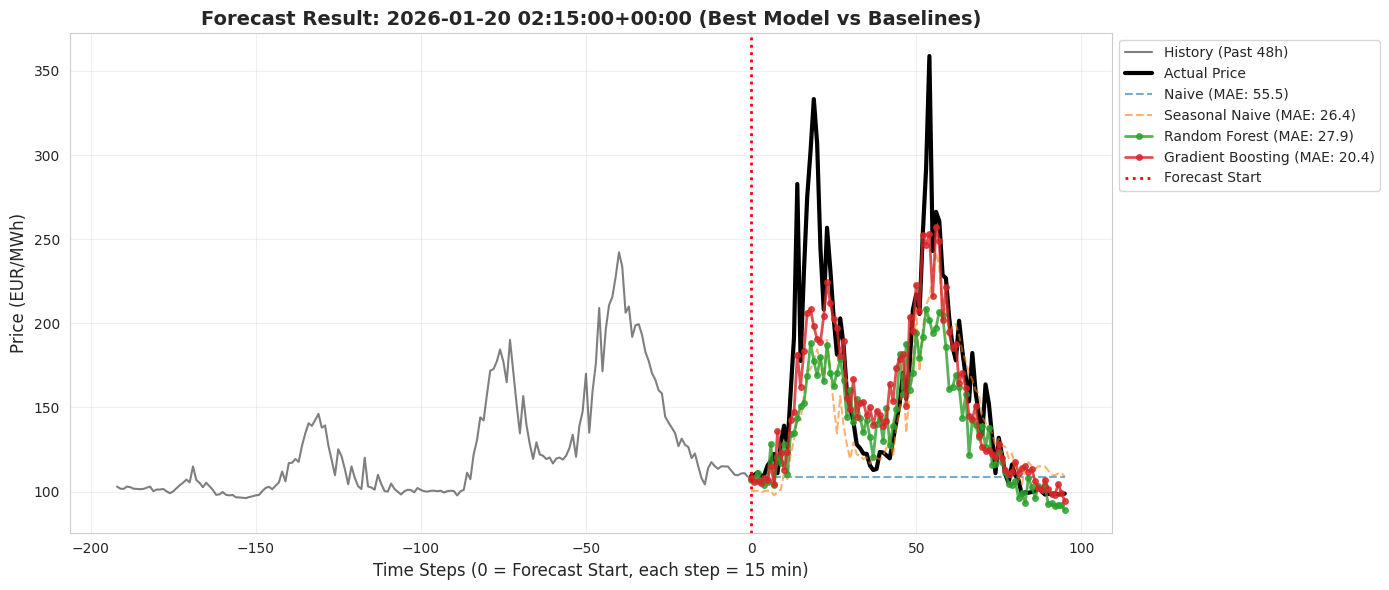

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# VISUALIZATION: 48h History + 24h Forecast
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))

# 1. Setup Data
# We want the last 48 hours of history relative to the LAST test window
# 'test_start' from the loop refers to the start of the forecast
# So we go back 192 steps (48h * 4 quarters) from there.
history_window = 96 * 2  # 48 hours
history_start_idx = test_start - history_window
history_end_idx = test_start

# Extract History
history_prices = df_15min['price'].iloc[history_start_idx : history_end_idx].values
history_time_axis = np.arange(-history_window, 0)

# Extract Actual Future
future_time_axis = np.arange(0, horizon)
actual_prices = all_forecasts['Actual'][-1]

# 2. Plot History (The context)
ax.plot(history_time_axis, history_prices, 'k-', linewidth=1.5, alpha=0.5, label='History (Past 48h)')

# 3. Plot Actual (The target)
ax.plot(future_time_axis, actual_prices, 'k-', linewidth=3, label='Actual Price')

# 4. Plot Algorithms (The forecasts)
# We access the last element [-1] of our storage lists
ax.plot(future_time_axis, all_forecasts['Naive'][-1], 
        '--', label=f"Naive (MAE: {all_results['Naive'][-1]:.1f})", alpha=0.6)

ax.plot(future_time_axis, all_forecasts['Seasonal Naive'][-1], 
        '--', label=f"Seasonal Naive (MAE: {all_results['Seasonal Naive'][-1]:.1f})", alpha=0.6)

ax.plot(future_time_axis, all_forecasts['Random Forest'][-1], 
        'o-', markersize=4, linewidth=2, label=f"Random Forest (MAE: {all_results['Random Forest'][-1]:.1f})", alpha=0.8)

ax.plot(future_time_axis, all_forecasts['Gradient Boosting'][-1], 
        'o-', markersize=4, linewidth=2, label=f"Gradient Boosting (MAE: {all_results['Gradient Boosting'][-1]:.1f})", alpha=0.8)

# 5. Styling
ax.axvline(x=0, color='r', linestyle=':', linewidth=2, label='Forecast Start')
ax.set_title(f"Forecast Result: {test_dates[-1]} (Best Model vs Baselines)", fontsize=14, fontweight='bold')
ax.set_xlabel("Time Steps (0 = Forecast Start, each step = 15 min)", fontsize=12)
ax.set_ylabel("Price (EUR/MWh)", fontsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
import numpy as np

# ---------------------------------------------------------
# SUMMARY: Walk-Forward Validation
# ---------------------------------------------------------
print("\n" + "="*80)
print("SUMMARY: Walk-Forward Validation Across Multiple Test Dates")
print("="*80)

# Dynamic date formatting
start_date = test_dates[0]
end_date = test_dates[-1]
if hasattr(start_date, 'strftime'):
    s_str = start_date.strftime('%Y-%m-%d %H:%M')
    e_str = end_date.strftime('%Y-%m-%d %H:%M')
else:
    s_str, e_str = str(start_date), str(end_date)

print(f"\nNumber of test periods: {num_tests}")
print(f"Test period length:     {test_window} observations (24 hours)")
print(f"Test date range:        {s_str} to {e_str}")

print("\n" + "-"*80)
print("Average Performance Across All Tests (sorted by MAE):")
print("-"*80)

# Calculate statistics for all methods
stats = {}
for method in all_methods:
    values = all_results[method]
    stats[method] = {
        'avg': np.mean(values),
        'std': np.std(values),
        'min': np.min(values),
        'max': np.max(values)
    }

# Sort methods by Average MAE (Ascending)
sorted_methods = sorted(all_methods, key=lambda m: stats[m]['avg'])
best_method = sorted_methods[0]
baseline_mae = stats['Naive']['avg'] if 'Naive' in stats else stats[sorted_methods[-1]]['avg']

for rank, method in enumerate(sorted_methods, 1):
    s = stats[method]
    
    # Calculate improvement vs baseline (Naive)
    imp_str = ""
    if method != 'Naive' and 'Naive' in stats:
        improvement = (baseline_mae - s['avg']) / baseline_mae * 100
        imp_str = f"({improvement:+.1f}% vs Naive)"
        
    print(f"\n{rank}. {method}:")
    print(f"   Average MAE: {s['avg']:.2f} EUR/MWh {imp_str}")
    print(f"   Std Dev:     {s['std']:.2f} EUR/MWh")
    print(f"   Range:       {s['min']:.2f} - {s['max']:.2f} EUR/MWh")

print(f"\n{'='*80}")
print(f"Overall Best Method: {best_method} (MAE: {stats[best_method]['avg']:.2f})")
print(f"{'='*80}")


SUMMARY: Walk-Forward Validation Across Multiple Test Dates

Number of test periods: 5
Test period length:     96 observations (24 hours)
Test date range:        2026-01-16 02:15 to 2026-01-20 02:15

--------------------------------------------------------------------------------
Average Performance Across All Tests (sorted by MAE):
--------------------------------------------------------------------------------

1. Gradient Boosting:
   Average MAE: 19.43 EUR/MWh (+37.9% vs Naive)
   Std Dev:     8.01 EUR/MWh
   Range:       8.44 - 28.40 EUR/MWh

2. Random Forest:
   Average MAE: 22.96 EUR/MWh (+26.7% vs Naive)
   Std Dev:     10.05 EUR/MWh
   Range:       8.49 - 35.34 EUR/MWh

3. Seasonal Naive:
   Average MAE: 23.99 EUR/MWh (+23.4% vs Naive)
   Std Dev:     8.79 EUR/MWh
   Range:       8.99 - 36.22 EUR/MWh

4. Naive:
   Average MAE: 31.32 EUR/MWh 
   Std Dev:     17.10 EUR/MWh
   Range:       7.31 - 55.45 EUR/MWh

Overall Best Method: Gradient Boosting (MAE: 19.43)


In [12]:
import pandas as pd

# ---------------------------------------------------------
# DETAILED RESULTS: Table & Best Per Period
# ---------------------------------------------------------
print("\n" + "="*110)
print("DETAILED RESULTS: Performance on Each Test Period")
print("="*110)

# 1. Prepare Date Strings (Handle Timestamp objects safely)
date_strings = []
for d in test_dates:
    if hasattr(d, 'date'):
        date_strings.append(str(d.date()))
    else:
        # Fallback if it's already a string
        date_strings.append(str(d).split(' ')[0])

results_data = {'Test Date': date_strings}

# 2. Add MAE columns for each method (Rounded for display)
for method in all_methods:
    results_data[method] = [round(x, 2) for x in all_results[method]]

# Create and Print DataFrame
results_df = pd.DataFrame(results_data)
print("\n" + results_df.to_string(index=False))

# 3. Highlight Best Method for Each Test
print("\n" + "-"*110)
print("Best Method by Test Period:")
print("-"*110)

for idx, d_str in enumerate(date_strings):
    # Extract scores for this specific test index
    scores = {method: all_results[method][idx] for method in all_methods}
    
    # Find winner
    best_method = min(scores, key=scores.get)
    best_mae = scores[best_method]
    
    # Print formatted row
    print(f"{d_str}: {best_method:<25} (MAE: {best_mae:.2f} EUR/MWh)")

print("="*110)


DETAILED RESULTS: Performance on Each Test Period

 Test Date  Naive  Seasonal Naive  Random Forest  Gradient Boosting
2026-01-16  33.41           25.89          29.06              28.40
2026-01-17  18.06           22.49          13.97              12.29
2026-01-18   7.31            8.99           8.49               8.44
2026-01-19  42.37           36.22          35.34              27.66
2026-01-20  55.45           26.37          27.93              20.38

--------------------------------------------------------------------------------------------------------------
Best Method by Test Period:
--------------------------------------------------------------------------------------------------------------
2026-01-16: Seasonal Naive            (MAE: 25.89 EUR/MWh)
2026-01-17: Gradient Boosting         (MAE: 12.29 EUR/MWh)
2026-01-18: Naive                     (MAE: 7.31 EUR/MWh)
2026-01-19: Gradient Boosting         (MAE: 27.66 EUR/MWh)
2026-01-20: Gradient Boosting         (MAE: 20.38 EUR/

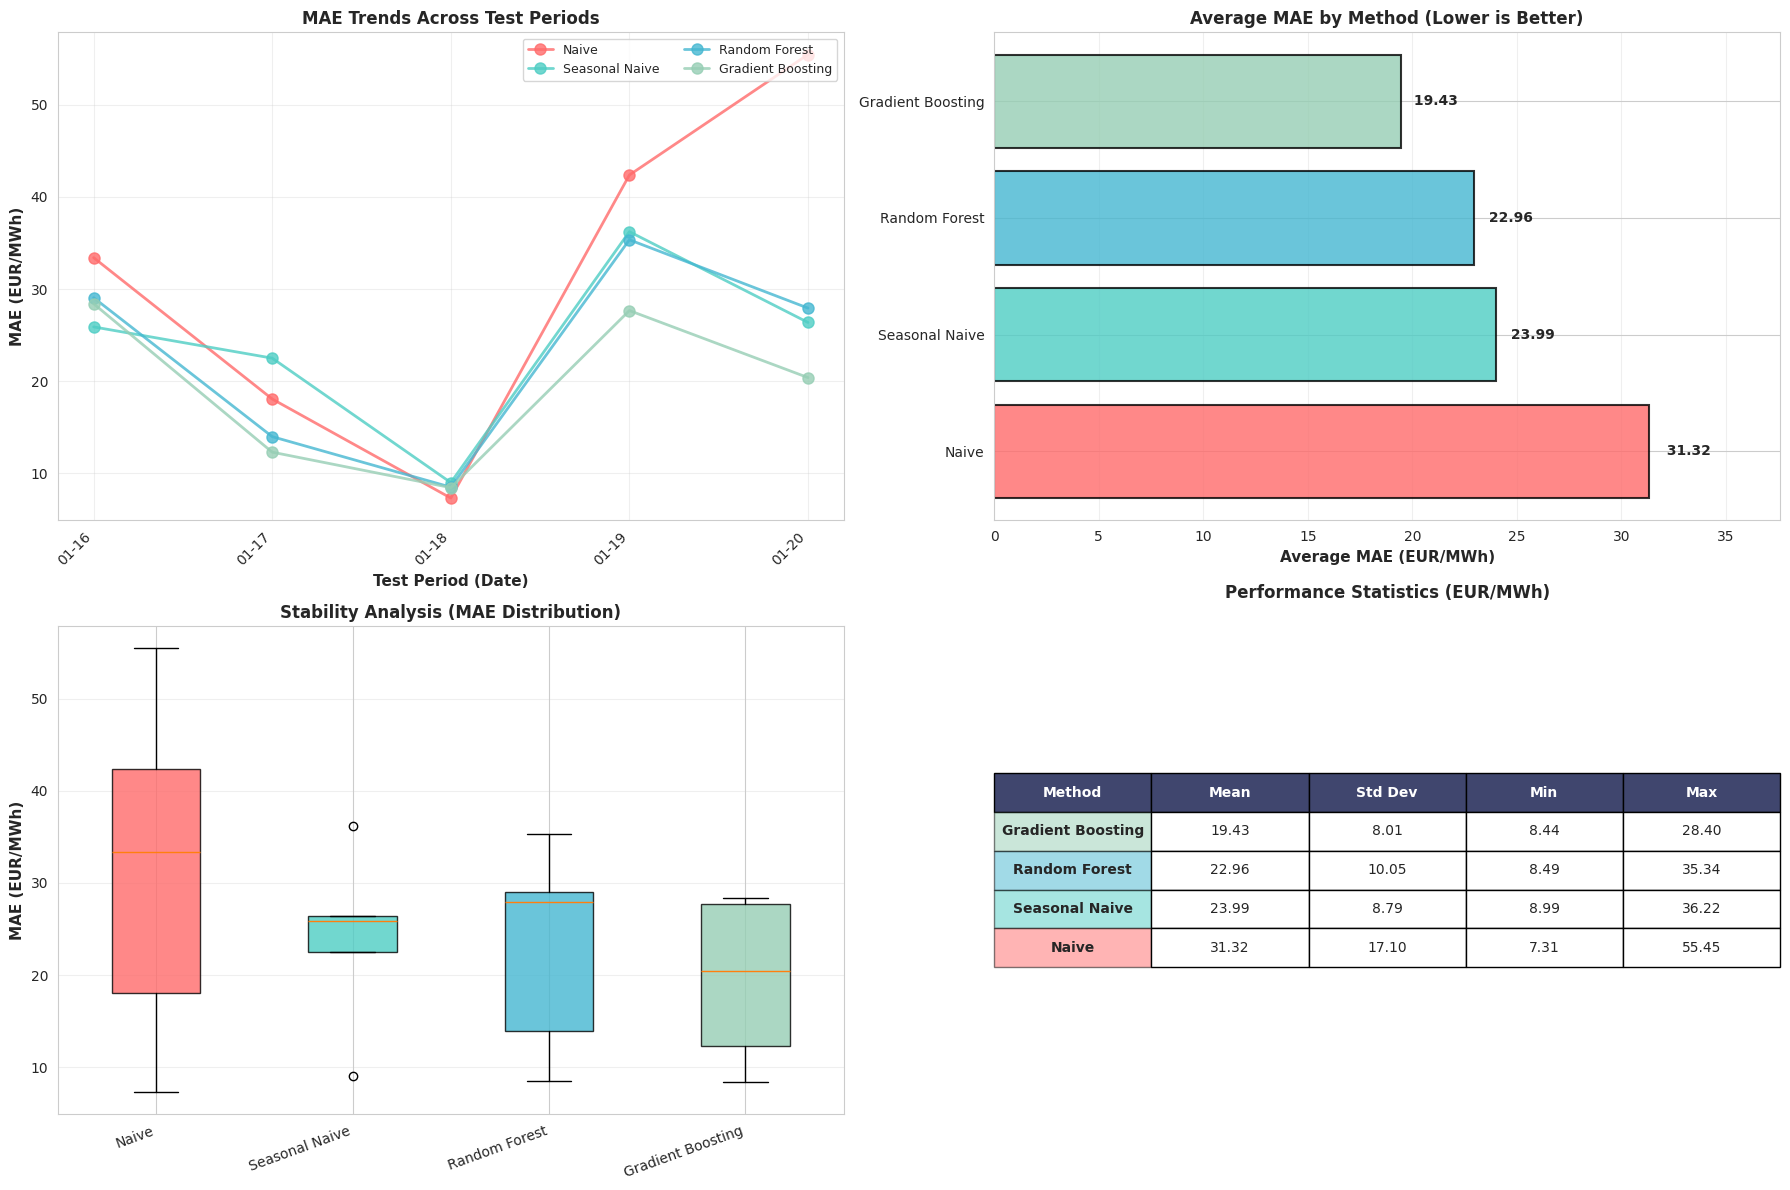


Plot Summary:
  Top Left: MAE trends across 5 test periods
  Top Right: Ranking of algorithms (Shortest bar is best)
  Bottom Left: Error spread (Smaller box = more stable)
  Bottom Right: Detailed statistics table


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# VISUALIZATION: Summary Dashboard
# ---------------------------------------------------------
# Ensure we strictly use the methods we actually trained
all_methods = list(all_results.keys())

# Setup the figure
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Dynamic Color Scheme
base_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA15E']
# Cycle colors if we have more methods than colors
colors = [base_colors[i % len(base_colors)] for i in range(len(all_methods))]
method_colors = {method: color for method, color in zip(all_methods, colors)}

# ---------------------------------------------------------
# 1. Line Plot: MAE over Time (Top Left)
# ---------------------------------------------------------
ax = axes[0, 0]

# Generate safe labels for dates
test_labels = []
for d in test_dates:
    if hasattr(d, 'strftime'):
        test_labels.append(d.strftime('%m-%d')) # Short format MM-DD
    else:
        test_labels.append(str(d).split(' ')[0][5:]) # Slice YYYY-MM-DD -> MM-DD

for method in all_methods:
    ax.plot(range(len(test_dates)), all_results[method], 'o-', linewidth=2, markersize=8, 
            label=method, color=method_colors[method], alpha=0.8)

ax.set_xlabel('Test Period (Date)', fontsize=11, fontweight='bold')
ax.set_ylabel('MAE (EUR/MWh)', fontsize=11, fontweight='bold')
ax.set_title('MAE Trends Across Test Periods', fontsize=12, fontweight='bold')
ax.set_xticks(range(len(test_dates)))
ax.set_xticklabels(test_labels, rotation=45, ha='right')
ax.legend(fontsize=9, loc='upper right', ncol=2)
ax.grid(True, alpha=0.3)

# ---------------------------------------------------------
# 2. Bar Plot: Average Performance (Top Right)
# ---------------------------------------------------------
ax = axes[0, 1]
avg_maes = [np.mean(all_results[m]) for m in all_methods]

# Sort: Worst (Highest MAE) at bottom, Best (Lowest MAE) at top? 
# Standard is usually Best at Top. 
# barh plots 0 at bottom. So we want Descending MAE order for the list.
sorted_idx = np.argsort(avg_maes)[::-1] 
sorted_methods = [all_methods[i] for i in sorted_idx]
sorted_colors = [method_colors[m] for m in sorted_methods]
sorted_maes = [avg_maes[i] for i in sorted_idx]

bars = ax.barh(sorted_methods, sorted_maes, color=sorted_colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, val in zip(bars, sorted_maes):
    width = bar.get_width()
    ax.text(width * 1.02, bar.get_y() + bar.get_height()/2.,
            f' {val:.2f}', ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Average MAE (EUR/MWh)', fontsize=11, fontweight='bold')
ax.set_title('Average MAE by Method (Lower is Better)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
# Add some breathing room for labels
ax.set_xlim(0, max(sorted_maes) * 1.2)

# ---------------------------------------------------------
# 3. Box Plot: Error Distribution (Bottom Left)
# ---------------------------------------------------------
ax = axes[1, 0]
box_data = [all_results[m] for m in all_methods]
bp = ax.boxplot(box_data, labels=all_methods, patch_artist=True)

# Color the boxes
for patch, method in zip(bp['boxes'], all_methods):
    patch.set_facecolor(method_colors[method])
    patch.set_alpha(0.8)

ax.set_ylabel('MAE (EUR/MWh)', fontsize=11, fontweight='bold')
ax.set_title('Stability Analysis (MAE Distribution)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=20, ha='right')

# ---------------------------------------------------------
# 4. Summary Table (Bottom Right)
# ---------------------------------------------------------
ax = axes[1, 1]
ax.axis('off')

# Prepare Data (Sorted by Best = Lowest Mean MAE)
table_idx = np.argsort(avg_maes) # Ascending
table_methods = [all_methods[i] for i in table_idx]

summary_data = []
for method in table_methods:
    data = all_results[method]
    summary_data.append([
        method,
        f"{np.mean(data):.2f}",
        f"{np.std(data):.2f}",
        f"{np.min(data):.2f}",
        f"{np.max(data):.2f}"
    ])

col_labels = ['Method', 'Mean', 'Std Dev', 'Min', 'Max']

table = ax.table(cellText=summary_data,
                colLabels=col_labels,
                cellLoc='center',
                loc='center',
                colColours=['#F0F0F0']*len(col_labels))

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style Header
for i in range(len(col_labels)):
    cell = table[(0, i)]
    cell.set_facecolor('#40466e')
    cell.set_text_props(weight='bold', color='white')

# Style Method Column
for i in range(1, len(summary_data) + 1):
    m_name = summary_data[i-1][0]
    cell = table[(i, 0)]
    cell.set_facecolor(method_colors[m_name])
    cell.set_alpha(0.5)
    cell.set_text_props(weight='bold')

ax.set_title('Performance Statistics (EUR/MWh)', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\nPlot Summary:")
print(f"  Top Left: MAE trends across {len(test_dates)} test periods")
print(f"  Top Right: Ranking of algorithms (Shortest bar is best)")
print(f"  Bottom Left: Error spread (Smaller box = more stable)")
print(f"  Bottom Right: Detailed statistics table")

Plotting forecasts for 5 periods with 48h context...


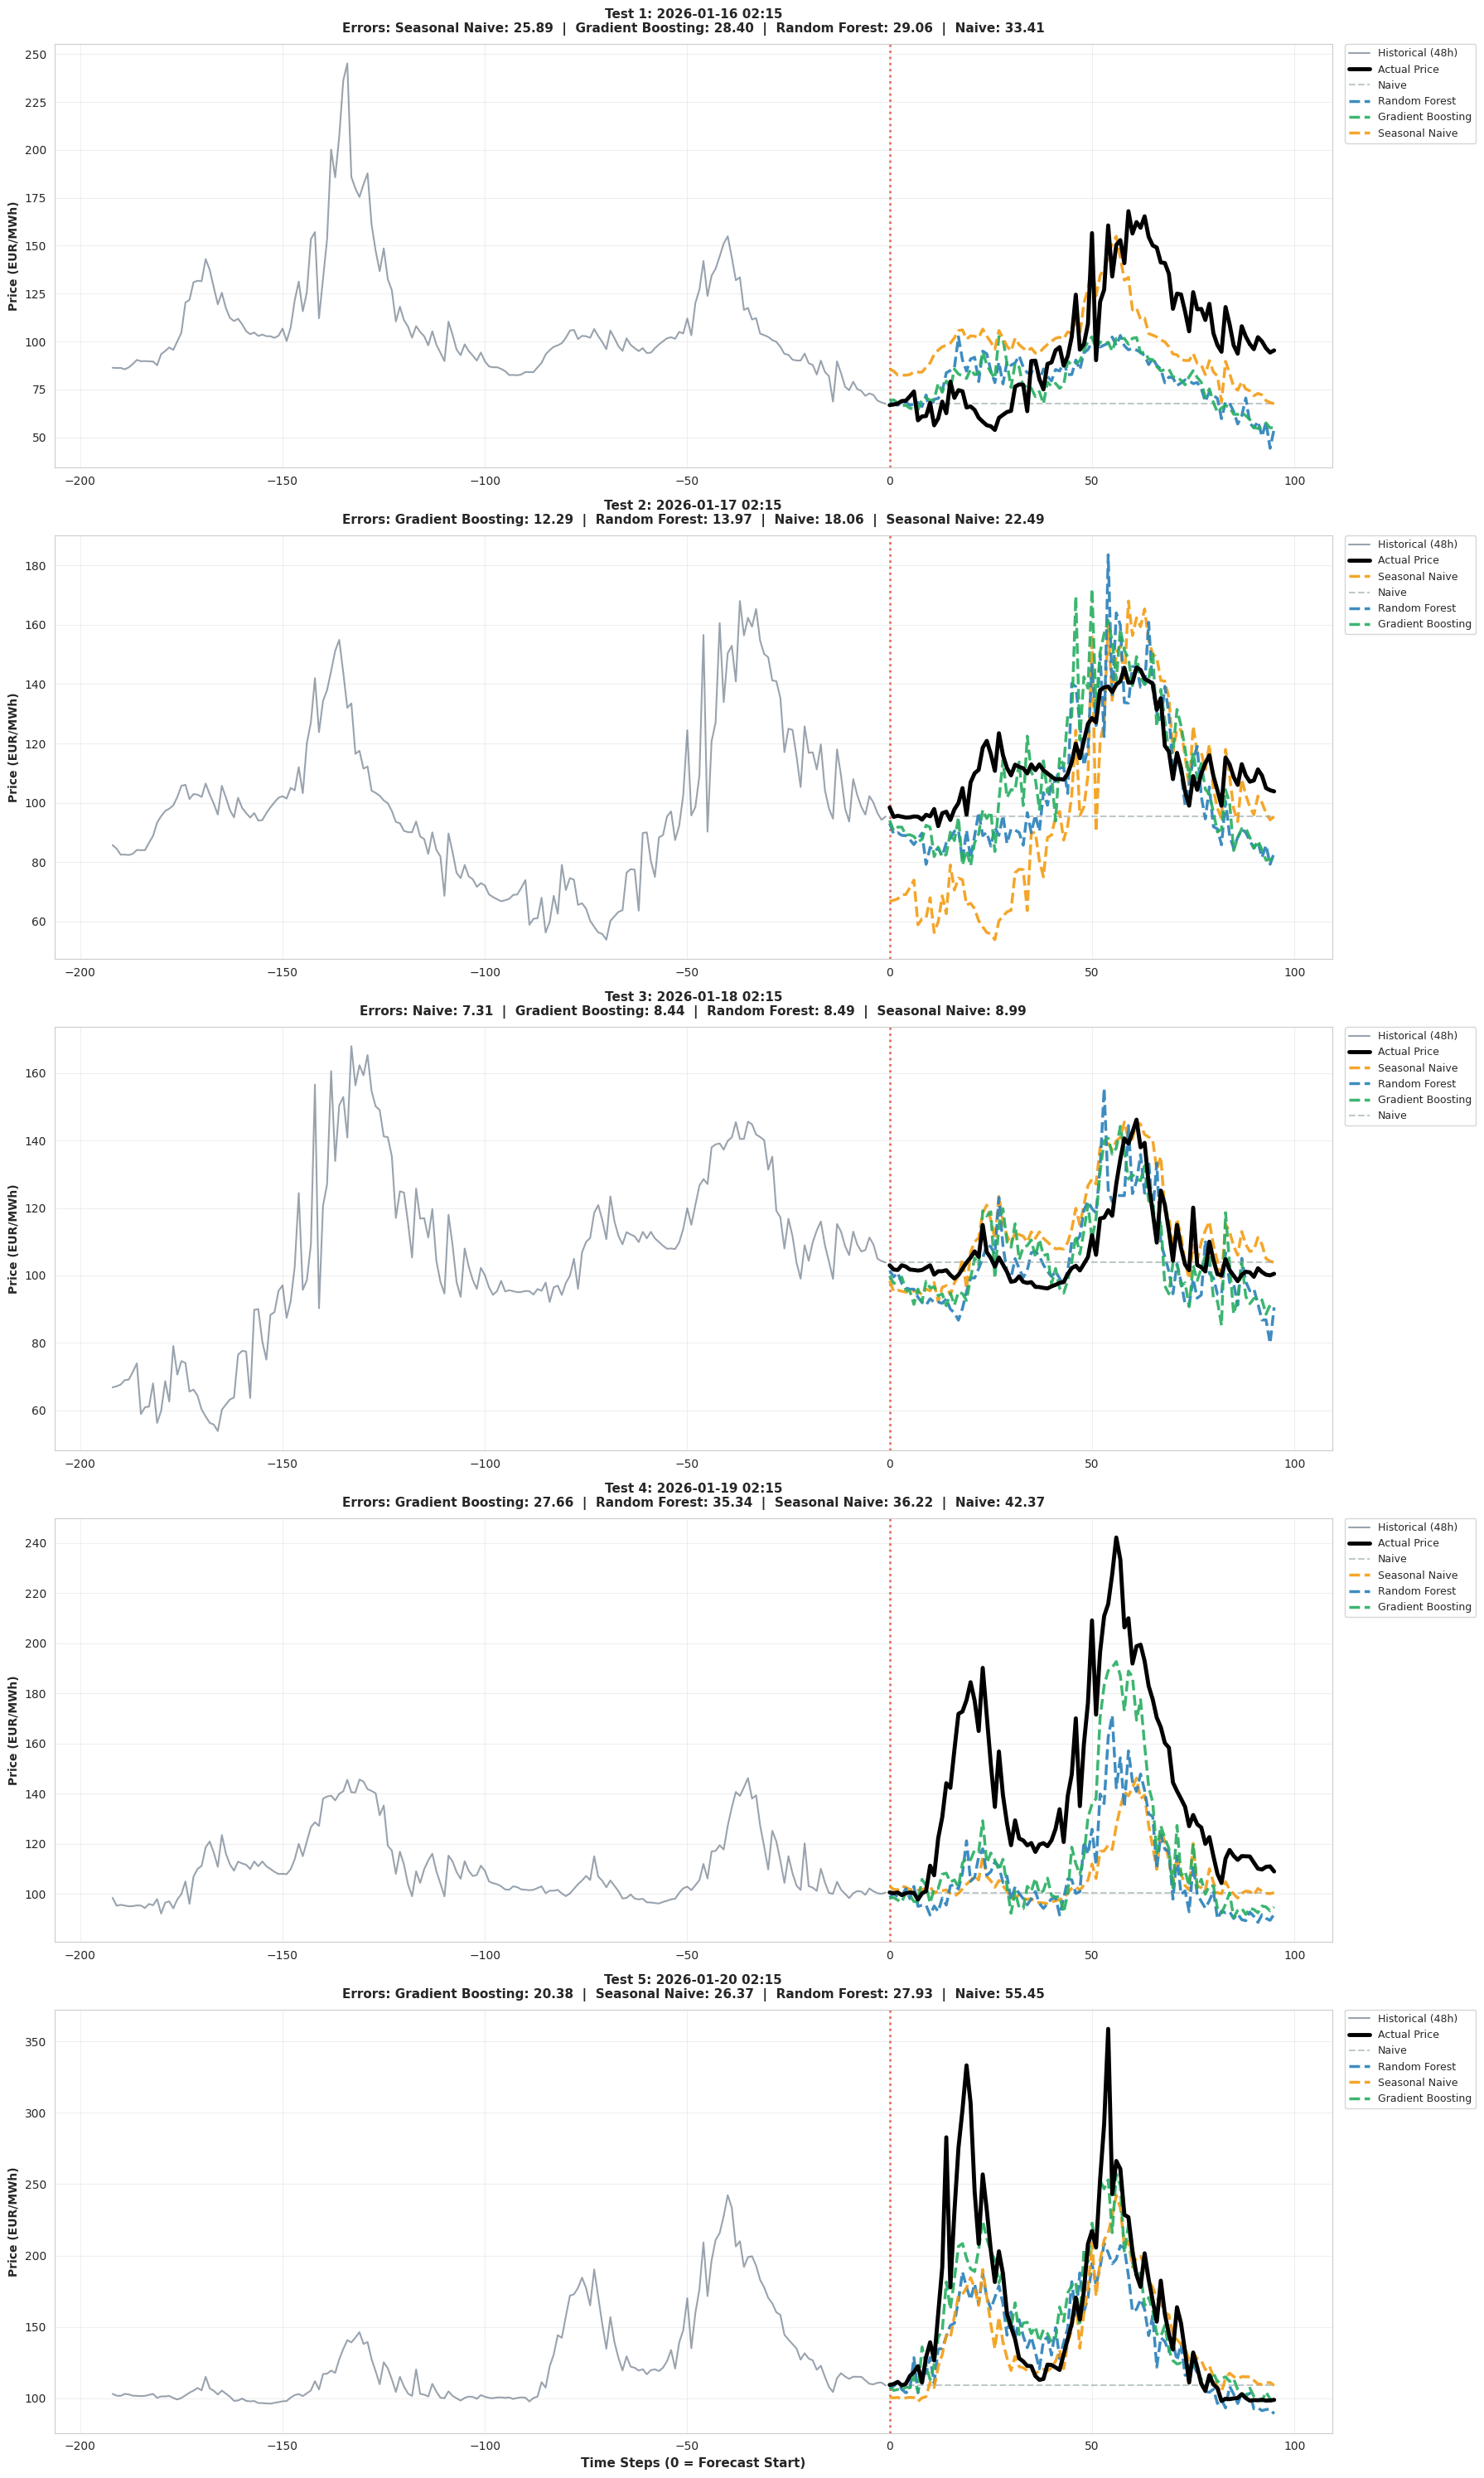


Completed visualization for 5 tests.


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# VISUALIZATION: All Test Periods with 48h History
# ---------------------------------------------------------

# 1. Setup
num_plots = len(test_dates)
# 48 hours * 4 quarters = 192 steps (adjusts automatically if 15min data)
history_steps = 96 * 2 

fig, axes = plt.subplots(num_plots, 1, figsize=(18, 6 * num_plots))
if num_plots == 1: axes = [axes] # Handle single case

# --- HIGH CONTRAST COLOR PALETTE ---
# Distinct colors for clarity:
# Actual = Black (Bold)
# Naive = Gray (Background)
# Seasonal = Orange
# Random Forest = Blue
# Gradient Boosting = Green (Often the winner)
custom_colors = {
    'Naive': '#95a5a6',           # Gray
    'Seasonal Naive': '#f39c12',  # Orange
    'Random Forest': '#2980b9',   # Blue
    'Gradient Boosting': '#27ae60'# Green
}

# Fallback generator for any extra methods
base_colors = ['#8e44ad', '#c0392b', '#16a085', '#2c3e50'] 

print(f"Plotting forecasts for {num_plots} periods with 48h context...")

# 2. Plotting Loop
for test_idx, ax in enumerate(axes):
    if test_idx >= num_plots: break
    
    # --- A. Data Recovery ---
    # We reconstruct the 'history' by looking back from the test start index
    current_test_start = len(df_15min) - (test_window * (num_tests - test_idx))
    
    # Get 48h History
    hist_start = max(0, current_test_start - history_steps)
    historical_data = df_15min['price'].iloc[hist_start : current_test_start].values
    
    # Get Actual Future
    actual_data = all_forecasts['Actual'][test_idx]
    
    # Create X-axes
    x_hist = np.arange(-len(historical_data), 0)
    x_fut = np.arange(0, len(actual_data))
    
    # --- B. Plotting ---
    # 1. History (Context)
    ax.plot(x_hist, historical_data, color='#34495e', linestyle='-', linewidth=1.5, 
            label='Historical (48h)', alpha=0.5, zorder=1)
    
    # 2. Actual (Ground Truth) - Bold Black Line
    ax.plot(x_fut, actual_data, 'k-', linewidth=3.5, label='Actual Price', zorder=10)
    
    # 3. Forecasts (Loop through available methods)
    mae_strs = []
    
    # Sort methods so 'Best' (lowest MAE) is plotted LAST (on top)
    sorted_methods_by_error = sorted(all_methods, key=lambda m: all_results[m][test_idx], reverse=True)
    
    for method in sorted_methods_by_error:
        # Get data
        pred = all_forecasts[method][test_idx]
        mae = all_results[method][test_idx]
        mae_strs.append(f"{method}: {mae:.2f}")
        
        # Pick Color
        c = custom_colors.get(method, base_colors[test_idx % len(base_colors)])
        
        # Style: Dashed lines for models
        # Make the lines slightly distinct in style too
        ls = '--'
        lw = 2.5
        alpha = 0.9
        
        if method == 'Naive': 
            lw = 1.5; alpha = 0.6 # Make naive less prominent
            
        ax.plot(x_fut, pred, linestyle=ls, linewidth=lw, label=method, color=c, alpha=alpha, zorder=5)

    # --- C. Styling ---
    # Separator Line
    ax.axvline(x=0, color='#e74c3c', linestyle=':', linewidth=2, alpha=0.8)
    
    # Title with Metrics
    # Safe date formatting
    t_date = test_dates[test_idx]
    try:
        date_str = t_date.strftime("%Y-%m-%d %H:%M")
    except:
        date_str = str(t_date).split('.')[0]
    
    # Join MAE scores for the title (Re-sort for reading: Best First)
    best_methods_first = sorted(all_methods, key=lambda m: all_results[m][test_idx])
    metric_str = "  |  ".join([f"{m}: {all_results[m][test_idx]:.2f}" for m in best_methods_first])
    
    ax.set_title(f"Test {test_idx+1}: {date_str}\nErrors: {metric_str}", fontsize=11, fontweight='bold', pad=10)
    
    ax.set_ylabel('Price (EUR/MWh)', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Legend - Outside right
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=9, borderaxespad=0)
    
    # X-Label only on last plot
    if test_idx == num_plots - 1:
        ax.set_xlabel('Time Steps (0 = Forecast Start)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nCompleted visualization for {num_plots} tests.")